keras version:  2.2.0
TensorFlow version:  1.7.1

Loading images...
tmp[0].shape:  (901, 385, 385, 3)
tmp[1].shape:  (719, 385, 385, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (1458, 73728)
val_bNFeatures[img].shape =  (162, 73728)
Train head...
Train...


/user/HS204/wm0015/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


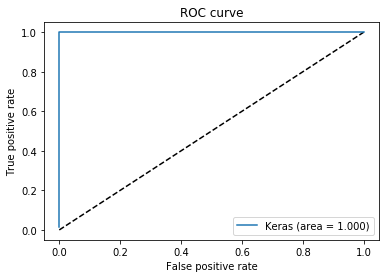

The score is......
 [0.037302185838789116, 0.9876543209876543, 0.9876543209876543, 0.9876543209876543]
Compute bottleneck features...
train_bNFeatures[img].shape =  (1458, 73728)
val_bNFeatures[img].shape =  (162, 73728)
Train head...
Train...


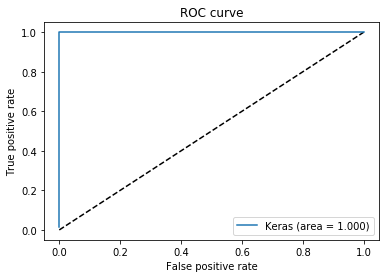

The score is......
 [0.03016852739232558, 0.9938271604938271, 0.9938271604938271, 0.9938271604938271]
Compute bottleneck features...


In [ ]:
# fold
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
# For some reason I have to tell it to use TensorFlows dimension ordering
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from time import time
import os
import tensorflow as tf
from keras import applications
from keras.utils import multi_gpu_model
from sklearn.metrics import roc_curve

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "2,3"
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Globals
VERBOSE = 0
ARCHITECTURE = 0
NORMALISE = 255
# Class 0 = backgrounds
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/normal/*'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/*'
# Prem..
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm'
# Calcs
CLASSDIR_0 = '/user/HS204/wm0015/student/allCalcs/0/*'
CLASSDIR_1 = '/user/HS204/wm0015/student/allCalcs/1/*'
MODEL_SAVE = '/vol/vssp/cvpwrkspc01/scratch/wm0015/models/best_model.h5'
BATCH_SIZE = 100
EPOCHS = 50
#INPUT_SHAPE = [256, 256, 3]
INPUT_SHAPE = [429, 429, 3]
INPUT_SHAPE = [385, 385, 3]
FOLDS = 5
PATIENCE = 500

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='/vol/vssp/mammo2/will/logs/new', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        fCount=0
        while os.path.exists(os.path.join(log_dir, 'training' + '_' + str(fCount))):
            fCount+=1
        training_log_dir = os.path.join(log_dir, 'training' + '_' + str(fCount))
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation' + '_' + str(fCount))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        
def getSensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def getSpecificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())        



def get_labels_one_hot(num_classes, class_id, num_samples):
    x = np.zeros((num_samples, num_classes))
    x[np.arange(num_samples),class_id] = 1
    return x

def fourCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    #model.add(Conv2D(32, (3,3), activation='relu'))   
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model
    
def fiveCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model
    
def bigCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(64, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(124, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(256, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(512, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model

def vgg():
    vggModel = applications.VGG19(weights = 'imagenet', include_top=False, input_shape = INPUT_SHAPE)
    # Add custom final layer
    model = vggModel.output
    model = Flatten()(model)
    model = Dense(2, activation='softmax')(model)
    model = keras.models.Model(inputs=vggModel.input, outputs=model)
    return model

def tlVGG(train_data, val_data):
    print('Compute bottleneck features...')
    vggModel = applications.VGG19(weights = "imagenet", include_top=False, input_shape = INPUT_SHAPE)
    # Freeze all layers
    for layer in vggModel.layers:
        layer.trainable = False
    # Add custom final layer
    bNModel = vggModel.output
    bNModel = Flatten()(bNModel)
    final_model = keras.models.Model(inputs=vggModel.input, outputs=bNModel)
    train_bNFeatures = {'img': 0, 'label': train_data['label']}
    val_bNFeatures = {'img': 0, 'label': val_data['label']}
    train_bNFeatures['img'] = final_model.predict(train_data['img'], batch_size=16)
    val_bNFeatures['img'] = final_model.predict(val_data['img'], batch_size=16)
    #Undo one hot - ROC does not work with onehot
    val_bNFeatures.update({'labelIndex': np.where(val_data['label']==1)[1]})
    print('train_bNFeatures[img].shape = ', train_bNFeatures['img'].shape)
    print('val_bNFeatures[img].shape = ', val_bNFeatures['img'].shape)

    print('Train head...')
    head = Sequential()
    #head.add(Dense(32, input_dim=train_bNFeatures['img'].shape[1], activation='relu'))
    head.add(Dense(2, activation='softmax'))    
    return head, train_bNFeatures, val_bNFeatures

    # Why oh why are they in a directory structure like this
def getPremFiles(imgPath, dataSpecs):
    import pydicom
    from fnmatch import fnmatch
    # First get all the 6mm lesions
    fileList = []
    for path, subdirs, files in os.walk(imgPath):
        for name in files:
            if fnmatch(name, '2D_dim2d.dcm'):
                fileList.append(os.path.join(path, name))
    # I can't remember why I thought dataSpecs was a good idea
    # I suppose this means that class 0 needs to be loaded in first
    dataSpecs['classLength'].append(len(fileList))
    
    # Load the files from filelist into an array
    print(len(fileList), ' Files found')
    print('Loading images...')
    dicomImg = np.asarray([])
    count = 0
    for f in fileList:
        dicomImg = np.append(dicomImg, pydicom.dcmread(f).pixel_array)
        count += 1
        print(count, '/', len(fileList))
    return dicomImg

def getDicomImages(data, paths, strMatch = '*.dcm', verbose = True):  
    import pydicom
    from fnmatch import fnmatch
    # Get file paths of images
    tmp = [[],[]]
    for index, p in enumerate(paths):
        fileList = []
        print(p)
        for path, subdirs, files in os.walk(p):
            for name in files:
                if fnmatch(name, strMatch): # '2D_dim2d.dcm'
                    fileList.append(os.path.join(path, name))
        data['classLength'].append(len(fileList))
        if len(fileList) == 0:
            print('MY_ERROR: NO FILES FOUND')
        # Load the files from filelist into an array
        print(len(fileList), ' Files found')
        print('Loading images...')
        data['img'] = np.asarray([])
        count = 0
        for f in fileList:
            tmp[index] = np.append(tmp[index], pydicom.dcmread(f).pixel_array)
            count += 1
            if verbose == True:
                print(count, '/', len(fileList))
    # Reshape the images
    tmp[0] = tmp[0].reshape((-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    tmp[0] = tmp[0][0:531,:,:,:]
    tmp[1] = tmp[1].reshape((-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    
    
    # Concatenate the classes
    print('tmp[0].shape: ', tmp[0].shape)
    print('tmp[1].shape: ', tmp[1].shape)
    data['img'] = np.concatenate((tmp[0],tmp[1]))
    # Add the channels
    print('data[Img].shape = ', data['img'].shape)
    data['img'] = np.concatenate((data['img'], data['img'], data['img']), axis = 3)
    print('data[Img].shape = ', data['img'].shape)
    return data

# For non dicom images
def getImages(data, paths):    
    tmp = [[],[]]
    for index, p in enumerate(paths):
        fileList = glob.glob(p) #'BengaliBMPConvert/*.bmp' 
        data['classLength'].append(len(fileList))
        tmp[index] = np.array([(cv2.imread(fname)) for fname in fileList])
    print('tmp[0].shape: ', tmp[0].shape)
    print('tmp[1].shape: ', tmp[1].shape)
    data['img'] = np.concatenate((tmp[0], tmp[1]))
    return data

def getImagesOld(path, dataSpecs):
    fileList = glob.glob(path) #'BengaliBMPConvert/*.bmp'   
    num = len(fileList)
    dataSpecs['classLength'].append(len(fileList))
    x = np.array([(cv2.imread(fname)) for fname in fileList])
    return x

    # Comment out for prem images
#     data['img'] = np.concatenate((
#             get_images(CLASSDIR_0, dataSpecs), # Class 0 (backgrounds)
#             get_images(CLASSDIR_1, dataSpecs) # Class 1 
#     ))         


def colourDrop3to1(data):   
    data['img'] = data['img'][:,:,:,0]
    data['img'] = np.reshape(data['img'], (data['img'].shape[0],data['img'].shape[1],data['img'].shape[2],1))
    print('new data shape = ', data['img'].shape)
    return data
    
def main():
    import keras
    print('keras version: ', keras.__version__)
    print('TensorFlow version: ', tf.__version__)
    print('\nLoading images...')
    
    # Get images
    data = {'img': 0, 'label': 0, 'classLength':[]}
    data = getImages(data, (CLASSDIR_0, CLASSDIR_1))
    #data = getDicomImages(data, (CLASSDIR_0, CLASSDIR_1), strMatch = '2D_dim2d.dcm')
    # Create one hot labels
    data['label'] = np.concatenate((
            get_labels_one_hot(2, 0, data['classLength'][0]), # Class 0 
            get_labels_one_hot(2, 1, data['classLength'][1]))) # Class 1
    
    # Normalise
    data['img'] = data['img']/NORMALISE 
    
    #data = colourDrop3to1(data)
        
    #___________________________________________________
#     # Get images and labels
#     data = {'img': 0, 'label': 0}
#     dataSpecs = {'classLength': []}
#     dataSpecs['classLength'] = []
    
#     # Comment out for prem images
# #     data['img'] = np.concatenate((
# #             get_images(CLASSDIR_0, dataSpecs), # Class 0 (backgrounds)
# #             get_images(CLASSDIR_1, dataSpecs) # Class 1 
# #     ))      

#     past1 = get_images(CLASSDIR_0, dataSpecs)
#     past2 = get_images(CLASSDIR_1, dataSpecs)
#     pastConcat = np.concatenate((past1, past2))


#     # Prem images
#     prem1 = getPremFiles('/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments', dataSpecs)
#     prem2 = getPremFiles('/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm', dataSpecs)
#     prem1 = prem1.reshape((-1, 429, 429, 1))
#     prem1 = prem1[0:537,:,:,:]
#     prem2 = prem2.reshape((-1, 429, 429, 1))
#     data['img'] = np.concatenate((prem1, prem2))
#     data['img'] = np.concatenate((data['img'], data['img'], data['img']), axis = 3)
#     print('prem1.shape: ', prem1.shape)
#     print('prem2.shape: ', prem2.shape)
#     print('data.shape = ', data['img'].shape)
#     #data.shape =  (1707, 429, 429, 1)


    
    valStats = []
    for crossVal in range(FOLDS):

        # Shuffle data
        seed = 33
        #np.random.seed(seed) # Has to be set before each use of random
        shuffleMask = np.random.permutation(data['img'].shape[0])    
        data['img'] = data['img'][shuffleMask, :, :, :]
        data['label'] = data['label'][shuffleMask, :]

        # Split traing and validation data        
        splitRatio = 0.9
        splitPoint = math.floor(data['img'].shape[0]*splitRatio)
        train_data = {'img': data['img'][0:splitPoint], 'label': data['label'][0:splitPoint]}
        val_data = {'img': data['img'][splitPoint:], 'label': data['label'][splitPoint:]}
        #Undo one hot - ROC does not work with onehot
        val_data.update({'labelIndex': np.where(val_data['label']==1)[1]})

        

        model, train_data, val_data = tlVGG(train_data, val_data)
        #model = fiveCNN()
        #model = multi_gpu_model(model, gpus=2)
        if ARCHITECTURE != 0:
            model.summary()  
        
        sgd = optimizers.SGD(lr=5, decay=1e-6, momentum=0.9, nesterov=True)
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #0.001
        model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                     metrics=['accuracy', getSensitivity, getSpecificity])
        tensorboard = TensorBoard(log_dir='/vol/vssp/mammo2/will/logs/new'.format(time()), write_images=True)

        # Data augmentation settings
        if (1 == 2):
            from keras.preprocessing.image import ImageDataGenerator
            trainDatagen = ImageDataGenerator(
                featurewise_center=True,
                featurewise_std_normalization=True,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)
            trainDatagen.fit(train_data['img'])
            valDatagen = ImageDataGenerator(
                featurewise_center=True,
                featurewise_std_normalization=True,
                #rotation_range=20,
                #width_shift_range=0.2,
                #height_shift_range=0.2,
                #horizontal_flip=True
                )
            valDatagen.fit(val_data['img'])
        
#         # Normalise myself
#         mean_data = np.mean(train_data['img'])
#         std_data = np.std(train_data['img'])
#         train_data['img'] = (train_data['img']-mean_data)/std_data
#         val_data['img'] = (val_data['img']-mean_data/std_data)
        
#        # Train, with data augmentation
#         print('Train...')
#         model.fit_generator(trainDatagen.flow(train_data['img'], train_data['label'], batch_size=32),
#                     steps_per_epoch=len(train_data['img']) / 32, epochs=EPOCHS, verbose=VERBOSE,
#                            callbacks=[
#                                TrainValTensorBoard(write_graph=False),
#                                EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1),
#                                ModelCheckpoint(filepath=MODEL_SAVE, monitor='val_accuracy', save_best_only=True)],
#                            validation_data=valDatagen.flow(x = val_data['img'], y = val_data['label']))
        

        
        
        
        # Train
        print('Train...')
        model.fit(train_data['img'], train_data['label'], 
                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                callbacks=[
                    TrainValTensorBoard(write_graph=False),
                    EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1),
                    ModelCheckpoint(filepath=MODEL_SAVE, monitor='val_accuracy', save_best_only=True)],
                validation_data=(val_data['img'], val_data['label']))
        
        # Restore best model
        #model.load_weights(MODEL_SAVE)
        
        # Produce ROC curve
        
        y_pred_keras = model.predict(val_data['img'])  
        y_true = val_data['labelIndex']
        y_score = y_pred_keras[:,1]
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_score)
        from sklearn.metrics import auc
        auc_keras = auc(fpr_keras, tpr_keras)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()


        # Evaluate
        score = model.evaluate(val_data['img'], val_data['label'], verbose=0)
        valStats.append(score)
        print('The score is......\n', score)
  

    valStats = np.asarray(valStats)
    print('Validations: \n', valStats[:, 1])
    print('Average loss: ', sum(valStats[:, 0])/FOLDS)
    print('Average validation: ', sum(valStats[:, 1])/FOLDS)
    
if __name__ == "__main__":
    main()

In [5]:
print('hello world')

hello world


In [28]:
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm'

def test(x):
    for _ in x:
        print(_)
test((CLASSDIR_0, CLASSDIR_1))

/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments
/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm


In [35]:
x = [[6.5308382717179665, 0.5925925925925926], [0.16470135086112553, 0.9444444444444444], [0.15422181794304907, 0.9444444444444444], [0.19875195217721256, 0.9382716049382716]] 
x = np.asarray(x)
print(x, '\n')
print(x[0][0])
print(x[:, 0])
print(x.shape)

[[6.53083827 0.59259259]
 [0.16470135 0.94444444]
 [0.15422182 0.94444444]
 [0.19875195 0.9382716 ]] 

6.5308382717179665
[6.53083827 0.16470135 0.15422182 0.19875195]
(4, 2)
